In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [2]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [3]:
Y_train

array([5, 5, 5, ..., 0, 0, 7])

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [4]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [5]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [6]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[1 1 3 ... 1 3 1] [5 5 5 ... 0 0 7]
0.14704878048780487
Iteration:  10
[3 3 0 ... 3 0 3] [5 5 5 ... 0 0 7]
0.2393170731707317
Iteration:  20
[3 3 0 ... 2 0 4] [5 5 5 ... 0 0 7]
0.30921951219512195
Iteration:  30
[3 3 8 ... 2 0 7] [5 5 5 ... 0 0 7]
0.3796341463414634
Iteration:  40
[3 3 8 ... 2 0 7] [5 5 5 ... 0 0 7]
0.43882926829268293
Iteration:  50
[3 3 8 ... 2 0 7] [5 5 5 ... 0 0 7]
0.4894390243902439
Iteration:  60
[3 3 5 ... 2 0 7] [5 5 5 ... 0 0 7]
0.5282926829268293
Iteration:  70
[3 3 5 ... 2 0 7] [5 5 5 ... 0 0 7]
0.5601951219512196
Iteration:  80
[3 3 5 ... 0 0 7] [5 5 5 ... 0 0 7]
0.5912682926829268
Iteration:  90
[3 3 5 ... 0 0 7] [5 5 5 ... 0 0 7]
0.6189512195121951
Iteration:  100
[3 5 5 ... 0 0 7] [5 5 5 ... 0 0 7]
0.6449024390243903
Iteration:  110
[5 5 5 ... 0 0 7] [5 5 5 ... 0 0 7]
0.6683170731707317
Iteration:  120
[5 5 5 ... 0 0 7] [5 5 5 ... 0 0 7]
0.6894878048780487
Iteration:  130
[5 5 5 ... 0 0 7] [5 5 5 ... 0 0 7]
0.706390243902439
Iteration:  140

~85% accuracy on training set.

In [7]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Let's look at a couple of examples:

Prediction:  [5]
Label:  5


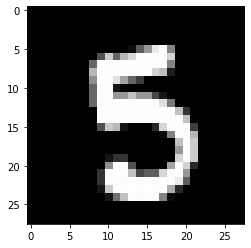

Prediction:  [5]
Label:  5


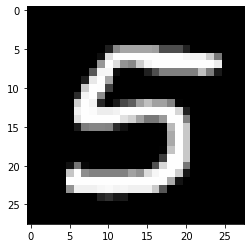

Prediction:  [5]
Label:  5


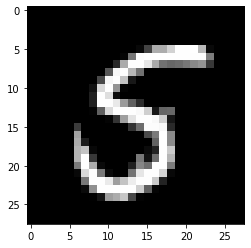

Prediction:  [5]
Label:  5


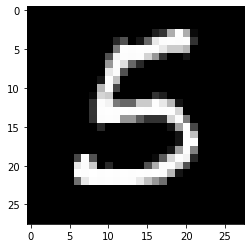

In [8]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

Finally, let's find the accuracy on the dev set:

In [9]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[1 6 9 4 8 1 0 7 7 9 5 1 8 1 4 7 8 3 3 8 5 5 4 1 8 9 2 0 7 5 1 4 4 5 1 5 7
 0 9 5 2 1 8 1 2 8 0 8 6 3 5 6 6 9 3 5 8 2 6 4 8 4 0 6 7 6 7 9 2 1 0 9 6 7
 6 9 4 0 3 2 3 2 7 6 5 5 7 5 7 3 7 9 3 0 7 9 6 8 8 6 3 5 5 2 9 6 1 2 3 9 7
 7 1 8 3 8 3 0 7 8 9 7 9 1 8 0 8 9 1 3 5 2 2 8 9 7 0 3 0 1 7 5 3 7 4 5 1 9
 2 6 3 7 9 3 4 8 7 7 3 1 0 3 7 3 3 8 0 0 6 7 6 9 1 2 2 5 6 8 1 8 2 6 1 9 3
 7 3 5 2 2 1 2 4 1 9 3 9 5 8 6 1 1 9 3 1 7 6 1 4 0 7 0 5 0 2 1 0 7 0 9 0 9
 8 2 9 3 3 3 6 4 4 9 2 1 3 0 8 1 0 7 7 2 2 7 4 3 6 1 1 6 2 7 4 4 8 9 3 2 6
 2 3 8 4 9 2 0 2 3 4 8 6 6 0 5 1 6 1 9 7 8 4 4 8 2 7 9 1 7 1 4 2 0 6 4 3 9
 7 4 3 2 8 1 4 1 3 3 0 1 4 2 6 9 0 0 1 3 5 0 9 4 4 6 4 1 9 7 2 4 4 0 9 2 5
 4 6 8 7 4 1 0 6 8 5 3 7 4 2 3 9 7 1 1 4 0 4 8 9 2 0 1 3 7 5 0 6 4 7 9 9 4
 8 5 3 2 3 3 5 7 0 2 2 6 8 5 0 9 3 4 9 2 6 8 5 1 1 1 2 9 4 2 7 4 0 7 3 9 2
 0 1 1 2 9 7 9 1 4 7 1 6 8 7 2 3 8 1 8 7 4 0 2 1 7 0 6 7 7 1 2 9 8 9 4 9 7
 6 1 3 3 4 0 6 8 2 8 5 1 0 3 4 4 4 7 7 9 5 1 0 2 8 8 6 1 8 1 5 3 4 5 0 8 5
 2 0 6 6 4 6 4 7 3 4 9 9 

0.845

Still 84% accuracy, so our model generalized from the training data pretty well.